Epoch [200/20000], Loss: 843.6967
Epoch [400/20000], Loss: 610.0256
Epoch [600/20000], Loss: 470.4178
Epoch [800/20000], Loss: 390.2112
Epoch [1000/20000], Loss: 343.4473
Epoch [1200/20000], Loss: 313.7527
Epoch [1400/20000], Loss: 292.1965
Epoch [1600/20000], Loss: 274.4094
Epoch [1800/20000], Loss: 258.5161
Epoch [2000/20000], Loss: 243.8605
Epoch [2200/20000], Loss: 230.2803
Epoch [2400/20000], Loss: 217.7645
Epoch [2600/20000], Loss: 206.3267
Epoch [2800/20000], Loss: 195.9706
Epoch [3000/20000], Loss: 186.6840
Epoch [3200/20000], Loss: 178.4404
Epoch [3400/20000], Loss: 171.1999
Epoch [3600/20000], Loss: 164.9120
Epoch [3800/20000], Loss: 159.5167
Epoch [4000/20000], Loss: 154.9459
Epoch [4200/20000], Loss: 151.1257
Epoch [4400/20000], Loss: 147.9783
Epoch [4600/20000], Loss: 145.4242
Epoch [4800/20000], Loss: 143.3844
Epoch [5000/20000], Loss: 141.7828
Epoch [5200/20000], Loss: 140.5481
Epoch [5400/20000], Loss: 139.6152
Epoch [5600/20000], Loss: 138.9260
Epoch [5800/20000], Loss

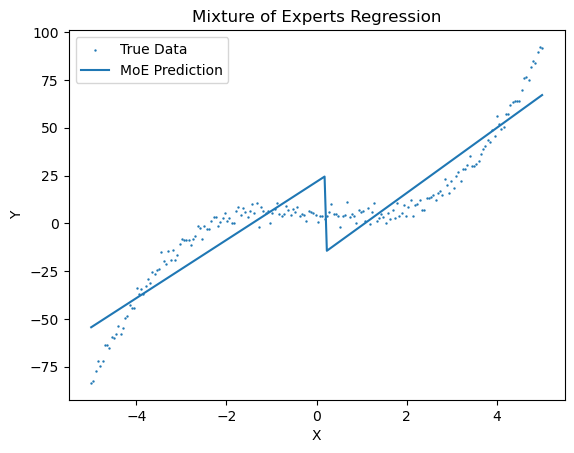

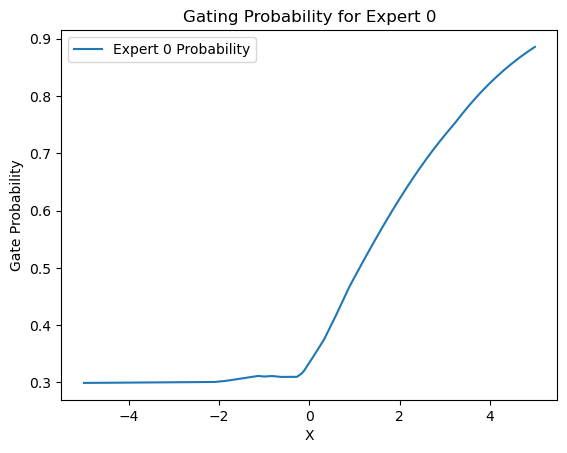

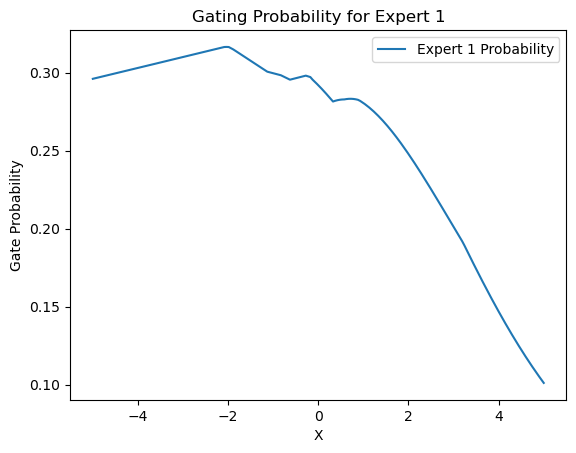

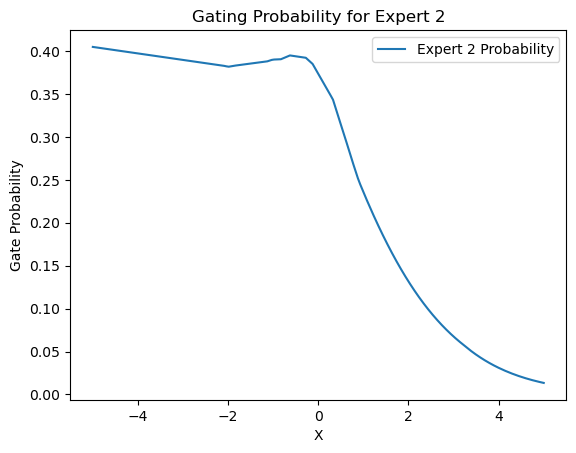

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# =============== 1. 生成一些示例数据（回归问题） ================
# 为了演示效果，造一段 -5 到 5 的数据，并人为设置成非线性分布
np.random.seed(42)
torch.manual_seed(42)

N = 200  # 样本数
X_np = np.linspace(-5, 5, N).reshape(-1, 1).astype(np.float32)
# 构造一个非线性关系 y
Y_np = 0.8 * X_np**3 - 2.0 * X_np + 5.0 + np.random.normal(0, 3, size=(N,1)).astype(np.float32)

# 转为 pytorch 的张量
X = torch.from_numpy(X_np)
Y = torch.from_numpy(Y_np)

# ============== 2. 定义 Mixture of Experts (MoE) 模型 ==============
class MoEModel(nn.Module):
    def __init__(self, input_dim, output_dim, num_experts, hidden_dim=16):
        """
        input_dim: 输入维度，一般为特征数
        output_dim: 输出维度，这里为1（回归）
        num_experts: 专家数量
        hidden_dim: gating网络的隐藏层维度（可调）
        """
        super(MoEModel, self).__init__()
        
        self.num_experts = num_experts
        
        # gating 网络: 将输入映射到 k 个专家的概率分布
        # 这里仅用一个简单的 2层MLP (input_dim->hidden_dim->num_experts)
        self.gating_network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_experts)
        )
        
        # k 个专家，每个专家是一个线性模型
        # 若想使用更复杂的模型，可以将每个专家替换为更深的网络
        self.experts = nn.ModuleList([
            nn.Linear(input_dim, output_dim) for _ in range(num_experts)
        ])
        
    def forward(self, x):
        """
        前向传播:
        1) gating_network 输出 shape: [batch_size, num_experts]
        2) 对 gating 输出做 softmax -> 得到 [batch_size, num_experts] 概率分布
        3) 每个专家输出 shape: [batch_size, output_dim]
        4) 将专家输出根据 gating 得到的概率分布加权求和
        """
        # 1) gating logit
        gating_logits = self.gating_network(x)               # shape: [B, k]
        # 2) softmax -> gating probabilities
        gating_probs = torch.softmax(gating_logits, dim=1)   # shape: [B, k]
        
        # 3) 每个专家分别计算输出
        expert_outputs = []
        for expert in self.experts:
            expert_outputs.append(expert(x))  # shape: [B, 1]
        
        # 将 list 拼成一个 tensor: shape [num_experts, batch_size, output_dim]
        # 转置为 [batch_size, num_experts, output_dim]
        expert_outputs = torch.stack(expert_outputs, dim=1)  # [B, k, output_dim]
        
       
        # out = (gating_probs.unsqueeze(2) * expert_outputs).sum(dim=1)  # [B, output_dim]

        max_expert_indices = gating_probs.argmax(dim=1)  # 形状: [B]


        out = expert_outputs[torch.arange(expert_outputs.size(0)), max_expert_indices, :]

        return out, gating_probs

# ============= 3. 实例化模型并定义损失、优化器 =============
input_dim = 1
output_dim = 1
num_experts = 3   # 可以自行设置专家数
hidden_dim = 16   # gating网络的隐藏层大小

model = MoEModel(input_dim, output_dim, num_experts, hidden_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# ============= 4. 训练循环 =============
num_epochs = 20000

for epoch in range(num_epochs):
    optimizer.zero_grad()
    # 前向传播
    predictions, gating_probs = model(X)
    loss = criterion(predictions, Y)
    # 反向传播
    loss.backward()
    optimizer.step()
    
    # 每隔一定轮数打印一下
    if (epoch+1) % 200 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# ============= 5. 可视化结果 =============
model.eval()
with torch.no_grad():
    pred, gating = model(X)

# 转回 numpy
X_plot = X_np.flatten()
Y_true = Y_np.flatten()
Y_pred = pred.numpy().flatten()

# 画出原始数据与预测结果
plt.figure()
plt.scatter(X_plot, Y_true, label="True Data", s=0.5)
plt.plot(X_plot, Y_pred, label="MoE Prediction")
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Mixture of Experts Regression")
plt.legend()
plt.show()

# 也可以可视化一下 gating 的概率随 x 的分布
gating_np = gating.numpy()  # shape: [N, k]
for expert_idx in range(num_experts):
    plt.figure()
    plt.plot(X_plot, gating_np[:, expert_idx], label=f"Expert {expert_idx} Probability")
    plt.xlabel("X")
    plt.ylabel("Gate Probability")
    plt.title(f"Gating Probability for Expert {expert_idx}")
    plt.legend()
    plt.show()


Epoch [100/500] - Loss: 198.5276
Epoch [200/500] - Loss: 125.6318
Epoch [300/500] - Loss: 109.3691
Epoch [400/500] - Loss: 107.0865
Epoch [500/500] - Loss: 106.4634


c:\Users\69042\.conda\envs\rl1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


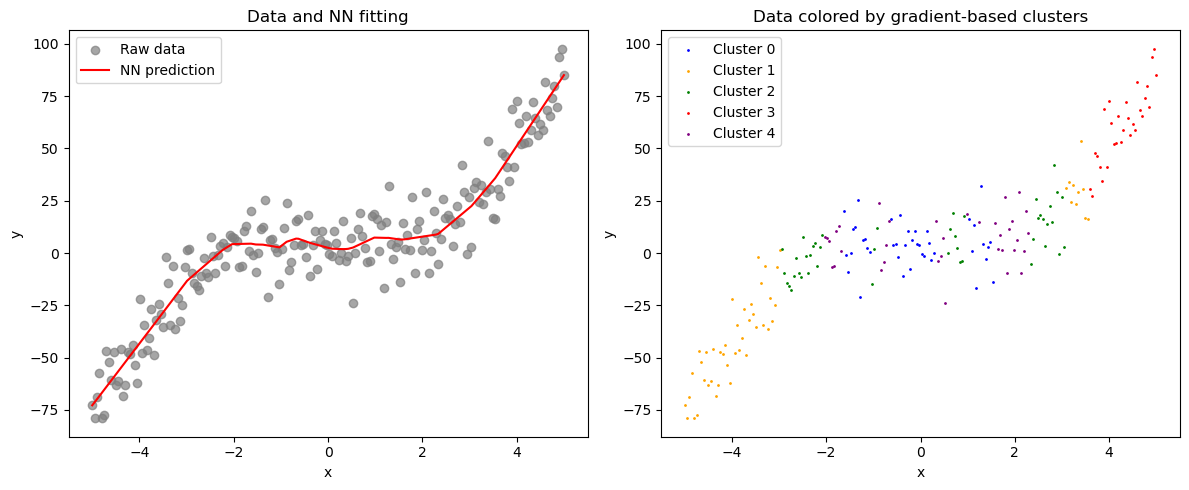

In [20]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# ============ 1) 数据生成 ============
np.random.seed(42)
torch.manual_seed(42)

N = 200
n_clusters = 5
X_np = np.linspace(-5, 5, N).reshape(-1, 1).astype(np.float32)
# 构造非线性关系 y = 0.8 x^3 - 2*x + 5 + 噪声
Y_np = 0.8 * X_np**3 - 2.0 * X_np + 5.0 \
       + np.random.normal(0, 10, size=(N, 1)).astype(np.float32)+ np.random.uniform(-10, 10, size=(N, 1)).astype(np.float32)

# 转为 PyTorch 张量
X = torch.from_numpy(X_np)
Y = torch.from_numpy(Y_np)

# ============ 2) 定义并训练可微模型 ============
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 一个简单的多层感知器：1 -> 32 -> 32 -> 1
        self.fc1 = nn.Linear(1, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = Net()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

num_epochs = 500
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    y_pred = model(X)
    loss = criterion(y_pred, Y)

    loss.backward()
    optimizer.step()

    if (epoch+1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {loss.item():.4f}")

# ============ 3) 计算每个样本点的梯度 ============
# 让 X 可以对输出进行反向传播，得到 d(model)/dX
X_grad = X.clone().detach()
X_grad.requires_grad_(True)

# 前向计算
y_pred_all = model(X_grad)

# 对每个样本单独做 backward，获取梯度值
grad_values = []
for i in range(N):
    # 清空梯度
    model.zero_grad()
    if X_grad.grad is not None:
        X_grad.grad.zero_()
    # 对单个样本执行 backward
    y_pred_all[i].backward(retain_graph=True)
    # X_grad.grad[i] 就是该样本的梯度 (仅 1 维)
    grad_values.append(X_grad.grad[i].item())

grad_values = np.array(grad_values).reshape(-1, 1)  # shape: (N, 1)

# ============ 4) 对梯度进行聚类 (KMeans) ============
# 这里示例: 分成 2~3 类都可以
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(grad_values)

# ============ 5) 可视化结果 ============
plt.figure(figsize=(12, 5))

# (a) 绘制散点和神经网络的预测曲线
plt.subplot(1, 2, 1)
plt.title("Data and NN fitting")
plt.scatter(X_np, Y_np, color="gray", alpha=0.7, label="Raw data")

# 画出 NN 预测曲线
x_plot = np.linspace(-5, 5, 200).reshape(-1, 1).astype(np.float32)
x_plot_torch = torch.from_numpy(x_plot)
y_plot_pred = model(x_plot_torch).detach().numpy()
plt.plot(x_plot, y_plot_pred, color="red", label="NN prediction")

plt.xlabel("x")
plt.ylabel("y")
plt.legend()

# (b) 根据梯度聚类给散点上色
plt.subplot(1, 2, 2)
plt.title("Data colored by gradient-based clusters")
colors = ["blue", "orange", "green", "red", "purple"]
for c in range(n_clusters):  # 这里是 n_clusters=2
    idx = (cluster_labels == c)
    plt.scatter(X_np[idx], Y_np[idx], color=colors[c], s=1,alpha=1, label=f"Cluster {c}")

plt.xlabel("x")
plt.ylabel("y")
plt.legend()

plt.tight_layout()
plt.show()



Running Cobyla...

Running CMA...

Running NGOpt...


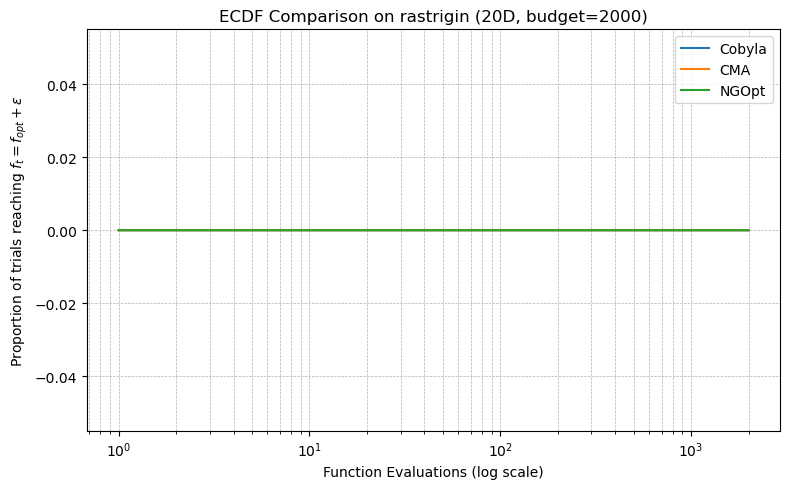

In [3]:
import nevergrad as ng
import numpy as np
import matplotlib.pyplot as plt

# 设置参数
D = 20
budget_type = "100D"
budget = 100 * D if budget_type == "100D" else 10 * D
num_trials = 15
target_precision = 1e-2  # 模拟论文中 f_t = f_opt + ε（f_opt 假设为 0）

# 测试函数（如 Sphere, Rastrigin, Ackley 等）
from nevergrad.functions import ArtificialFunction
func_name = "rastrigin"
func = ArtificialFunction(name=func_name, block_dimension=D, noise_level=0.0)

# 需要测试的优化器
optimizers = ["Cobyla", "CMA", "NGOpt"]
results_ecdf = {}

# 主实验循环
for opt_name in optimizers:
    print(f"\nRunning {opt_name}...")
    success_steps = []

    for trial in range(num_trials):
        optimizer = ng.optimizers.registry[opt_name](parametrization=D, budget=budget)
        losses = []
        recommendation = None
        for i in range(budget):
            x = optimizer.ask()
            y = func(x.value)
            optimizer.tell(x, y)
            losses.append(y)
            if y <= target_precision:
                success_steps.append(i + 1)  # 第 i+1 次函数调用达到目标
                break
        else:
            success_steps.append(np.inf)  # 如果未达到目标

    results_ecdf[opt_name] = np.array(success_steps)

# ECDF 绘制
plt.figure(figsize=(8, 5))

max_eval = budget
x_vals = np.arange(1, max_eval + 1)

for opt_name in optimizers:
    steps = results_ecdf[opt_name]
    ecdf = [(steps <= x).sum() / num_trials for x in x_vals]
    plt.plot(x_vals, ecdf, label=opt_name)

plt.xscale("log")
plt.xlabel("Function Evaluations (log scale)")
plt.ylabel("Proportion of trials reaching $f_t = f_{opt} + \\varepsilon$")
plt.title(f"ECDF Comparison on {func_name} ({D}D, budget={budget})")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
import nevergrad as ng
from nevergrad.functions import ArtificialFunction

D = 5
func_name = "rastrigin"
func = ArtificialFunction(name=func_name, block_dimension=D, noise_level=0,rotation=False,translation_factor=False)

def square(x):
    return sum((x - .5)**2)

optimizer = ng.optimizers.BO(parametrization=5, budget=100)
recommendation = optimizer.minimize(func)
print(recommendation.value)  # recommended value


[ 0.23350986 -0.09656528  0.85423605  1.25256303 -0.10788971]


In [53]:
import nevergrad as ng
from nevergrad.functions import ArtificialFunction
import numpy as np

def run_experiment(noise_level, D=10, budget=100, seed=42):
    # 创建带/不带噪声的 Rastrigin 函数
    func = ArtificialFunction(
        name="rastrigin",
        block_dimension=D,
        noise_level=noise_level,
        rotation=False,
    )
    np.random.seed(seed)
    optimizer = ng.optimizers.Cobyla(parametrization=D, budget=budget)
    recommendation = optimizer.minimize(func)

    x_rec = recommendation.value
    f_rec = func(x_rec)
    f_opt = 0.0  # 最优值为 0（已关闭 translation）
    distance = np.linalg.norm(x_rec)  # 与最优点 0 的距离

    print(f"\n--- Noise level: {noise_level} ---")
    print(f"Recommended x: {x_rec}")
    print(f"Function value at x: {f_rec:.4f}")
    print(f"Function gap Δf: {f_rec - f_opt:.4f}")
    print(f"Distance to optimum: {distance:.4f}")

    return f_rec, distance

# 运行两种实验
run_experiment(noise_level=0.0)   # 无噪声
run_experiment(noise_level=0.1)   # 有噪声



--- Noise level: 0.0 ---
Recommended x: [-0.18508402  1.26509071  0.05088128 -0.02782203  0.83418566  0.51078495
  0.20865137 -0.14257804  0.27253706 -0.08488463]
Function value at x: 5.9778
Function gap Δf: 5.9778
Distance to optimum: 1.6554

--- Noise level: 0.1 ---
Recommended x: [-0.13523783 -0.3477137   1.19709762  0.08973664  0.10611336  1.0582219
 -0.19002097 -0.26122206 -0.19272828  0.24042358]
Function value at x: 43.6727
Function gap Δf: 43.6727
Distance to optimum: 1.7061


(43.67270908456437, 1.7060702524628226)